In [1]:
from google.colab import drive
import pandas as pd

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification'

/content/drive/MyDrive/Georgia Tech/Machine Learning-CS7641/Assignments/Assignment #1/Wine_Classification


In [4]:
df = pd.read_csv('winequality-white.csv', sep=';')

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32c5b522d0>,
      dtype=object)

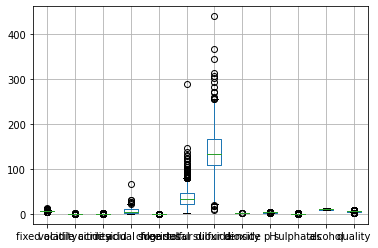

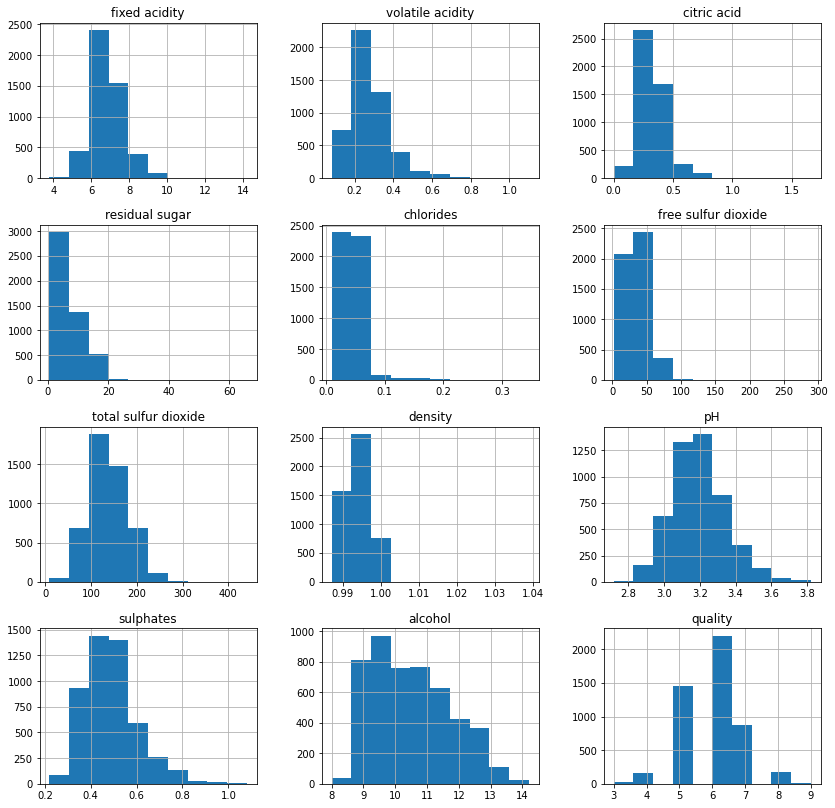

In [6]:
df.boxplot()
df.hist(figsize=(14,14))

In [7]:
# Defining X and y
X = df.drop('quality', axis = 1)
y = df['quality']

In [25]:
# Rewieght Calcultaion
def reweight_cal(y, b=0.9999):
  cls_num_list = y.value_counts().tolist()
  b_raised = [b**x for x in cls_num_list]
  denom = [1 - x for x in b_raised]
  num = 1 - b
  reweight_unnorm = [num/x for x in denom]
  norm_factor = len(cls_num_list) / sum(reweight_unnorm)
  reweight_norm = [norm_factor*x for x in reweight_unnorm]
  return reweight_norm


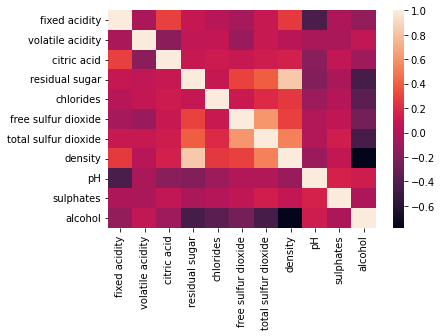

In [8]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr)

In [ ]:
#X = X.drop('density', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                        random_state=27, test_size = 0.25)

In [ ]:
train = pd.concat([X_train, y_train], axis=1)

In [ ]:
train_X = train.drop('quality', axis=1)
train_y = train['quality']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.15, stratify= train_y)

In [ ]:
print(y.value_counts())
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64
6    1401
5     929
7     561
8     111
4     104
3      13
9       3
Name: quality, dtype: int64
6    247
5    164
7     99
8     20
4     18
3      2
9      1
Name: quality, dtype: int64
6    550
5    364
7    220
8     44
4     41
3      5
9      1
Name: quality, dtype: int64


In [ ]:
#Label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
_ = le.fit(y_train)
y_train_tra = le.transform(y_train)
y_val_tra = le.transform(y_val)
y_test_tra = le.transform(y_test)

In [ ]:
le.classes_

array([3, 4, 5, 6, 7, 8, 9])

In [ ]:
normal_col = ['fixed acidity', 'citric acid', 'total sulfur dioxide', 'pH',
              'alcohol', 'free sulfur dioxide', 'density']
skewd_col = ['volatile acidity', 'residual sugar', 'chlorides', 
            'sulphates']

In [ ]:
#Make Copy of X_train and X_test
X_train_stand = X_train.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer

normal_pipeline = Pipeline(steps = [('scale', StandardScaler())])
skewd_pipline = Pipeline(steps = [('sk_scale', PowerTransformer())])

full_preprocessor = ColumnTransformer(transformers=[
        ('normal_transform', normal_pipeline, normal_col),
        ('skewd_transform', skewd_pipline, skewd_col)])

X_train_stand = full_preprocessor.fit_transform(X_train_stand)
X_val_stand = full_preprocessor.transform(X_val_stand)
X_test_stand = full_preprocessor.transform(X_test_stand)


In [ ]:
df_X = pd.DataFrame(X_train_stand, columns= X_train.columns)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f37aa1f09d0>,
      dtype=object)

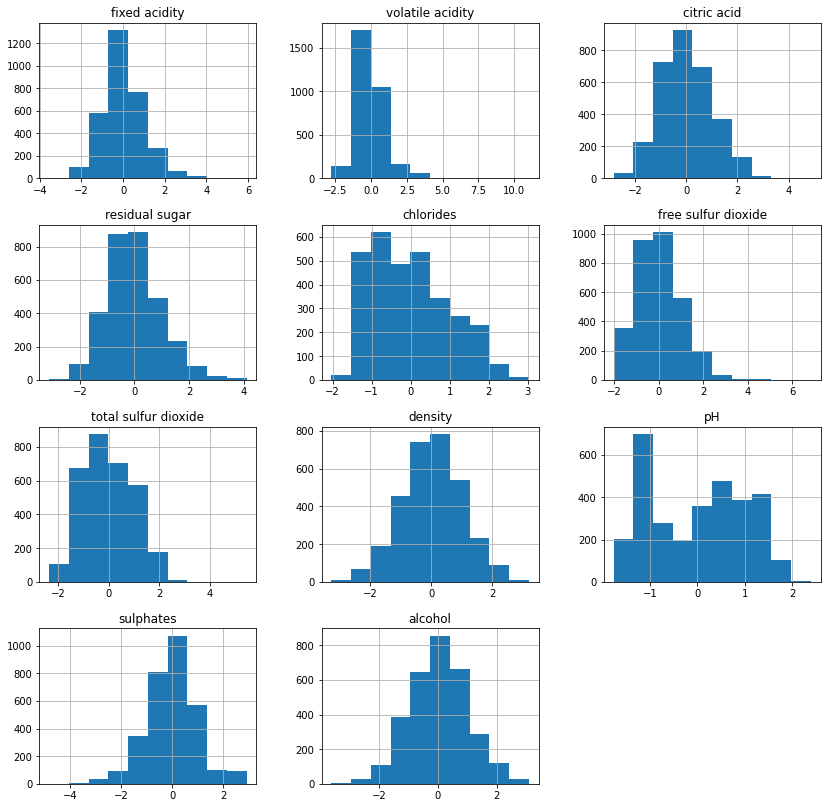

In [ ]:
df_X.hist(figsize=(14,14))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score
from sklearn.utils import resample
import numpy as np

In [ ]:
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  precision_list = []
  recall_list = []
  f1_score_list = []
  model.eval()

  with torch.no_grad():
    for x, y_true in loader:
      x = x.to(device = device)
      y = y_true.to(device = device)

      scores = model.forward(x.float())
      _, y_pred = scores.max(1)
      y_pred = y_pred.to(y_true.device)

      # tp = (y_true * y_pred).sum()
      # tn = ((1 - y_true) * (1 - y_pred)).sum()
      # fp = ((1 - y_true) * y_pred).sum()
      # fn = (y_true * (1 - y_pred)).sum()

      # epsilon = 1e-7
          
      precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
      precision_list.append(precision.tolist())
      recall = recall_score(y_pred, y_true, average='macro', zero_division=1)
      recall_list.append(recall.tolist())
      f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
      f1_score_list.append(f1.tolist())

      num_correct += (y_pred == y_true).sum()
      num_samples += y_pred.size(0)
  
  # return np.mean(f1_score_list)
  print(f'Got {num_correct} / {num_samples} with accuracy of {float(num_correct)/ float(num_samples)*100:.2f}')
  print(f'Average Precision Score: {np.mean(precision_list):.2f}')
  print(f'Average recall Score: {np.mean(recall_list):.2f}')
  print(f'Average f1-Score: {np.mean(f1_score_list):.2f}')

  

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer):
      super(NN, self).__init__()
      self.fc1 = nn.Linear(input_size, hidden_layer)
      self.fc2 = nn.Linear(hidden_layer, num_classes)
      # self.fc3 = nn.Linear(15, num_classes)
      self.sig = nn.Sigmoid()
      self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
      x = self.fc1(x)
      x = self.sig(x)
      # x = self.leaky_relu(self.fc2(x))
      x = self.fc2(x)
      return x

In [ ]:
#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
y_train.value_counts()

6    1401
5     929
7     561
8     111
4     104
3      13
9       3
Name: quality, dtype: int64

In [ ]:
#Hyperparameters
input_size = 11
num_classes = 7
hidden_layer = 20
learning_rate = 0.055
batch_size = 32
num_epochs = 45
regularization_rate = 0.001

In [ ]:
#Converting Dataframe to Tensors
X_train_tensor = torch.tensor(X_train_stand)
X_val_tensor = torch.tensor(X_val_stand)
X_test_tensor = torch.tensor(X_test_stand)
y_train_tensor = torch.tensor(y_train_tra)
y_val_tensor = torch.tensor(y_val_tra)
y_test_tensor = torch.tensor(y_test_tra)

In [ ]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor) 

In [ ]:
#Loading Train and Test dataset
train_data_load = DataLoader(dataset = train_data, batch_size = batch_size)
val_data_load = DataLoader(dataset = val_data, batch_size= batch_size)
test_data_load = DataLoader(dataset = test_data, batch_size = batch_size)

In [ ]:
#Initialize Network
model = NN(input_size = input_size, num_classes = num_classes, hidden_layer= hidden_layer).to(device)

In [ ]:
#Defining Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, weight_decay= regularization_rate)

In [ ]:
epoch_c = []
val_score = []
train_score = []
epoch_loss = []
batch_loss = []
for epoch in range(num_epochs):
  for batch_idx, (data, targets) in enumerate(train_data_load):
    data = data.to(device=device)
    targets = targets.to(device=device)
    #Forward

    scores = model.forward(data.float())
    loss = criterion(scores, targets)
    batch_loss.append(loss.tolist())

    #backward
    optimizer.zero_grad()
    loss.backward()

    #Update Parameters
    optimizer.step()

    
    print(f'Batch # {batch_idx} Loss: {loss:.2f}')

  epoch_loss.append(np.mean(batch_loss))
  epoch_c.append(epoch)
  train_score.append(check_accuracy(train_data_load, model))
  val_score.append(check_accuracy(val_data_load, model))
  print(f'---> Epoch # {epoch} loss: {epoch_loss[epoch]:.2f}')
  print(f'-----> Validation score @ {epoch}: {val_score[epoch]:.2f}')

Batch # 0 Loss: 1.11
Batch # 1 Loss: 1.12
Batch # 2 Loss: 0.94
Batch # 3 Loss: 0.99
Batch # 4 Loss: 1.24
Batch # 5 Loss: 1.23
Batch # 6 Loss: 0.96
Batch # 7 Loss: 1.07
Batch # 8 Loss: 1.17
Batch # 9 Loss: 1.08
Batch # 10 Loss: 0.95
Batch # 11 Loss: 1.01
Batch # 12 Loss: 0.79
Batch # 13 Loss: 1.42
Batch # 14 Loss: 0.89
Batch # 15 Loss: 1.11
Batch # 16 Loss: 1.09
Batch # 17 Loss: 1.12
Batch # 18 Loss: 1.07
Batch # 19 Loss: 1.13
Batch # 20 Loss: 0.96
Batch # 21 Loss: 1.32
Batch # 22 Loss: 0.92
Batch # 23 Loss: 1.05
Batch # 24 Loss: 1.14
Batch # 25 Loss: 1.01
Batch # 26 Loss: 1.17
Batch # 27 Loss: 1.03
Batch # 28 Loss: 1.15
Batch # 29 Loss: 1.02
Batch # 30 Loss: 1.14
Batch # 31 Loss: 0.96
Batch # 32 Loss: 1.20
Batch # 33 Loss: 1.36
Batch # 34 Loss: 0.92
Batch # 35 Loss: 0.83
Batch # 36 Loss: 1.27
Batch # 37 Loss: 1.05
Batch # 38 Loss: 1.14
Batch # 39 Loss: 1.06
Batch # 40 Loss: 0.99
Batch # 41 Loss: 0.94
Batch # 42 Loss: 0.99
Batch # 43 Loss: 0.86
Batch # 44 Loss: 0.95
Batch # 45 Loss: 0.9

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curve_mlp(epoch, train_score, val_score, x_label, y_label, title):
  plt.grid()
  plt.plot(epoch, train_score, 'r', label= 'Training Score')
  plt.plot(epoch, val_score, 'b', label = 'Validation Score')
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.title(title)
  plt.legend(loc='best')

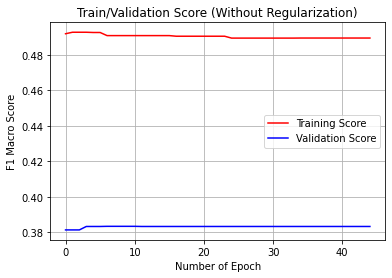

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Without Regularization)')

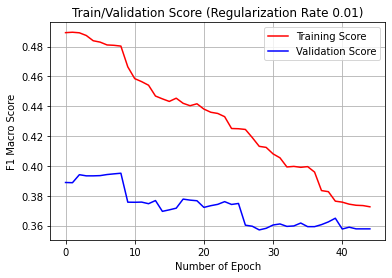

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Regularization Rate {})'.format(regularization_rate))

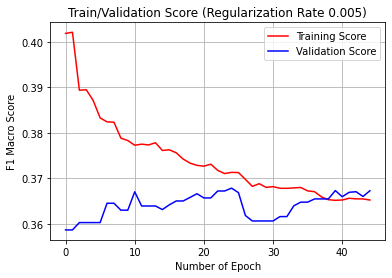

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Regularization Rate {})'.format(regularization_rate))

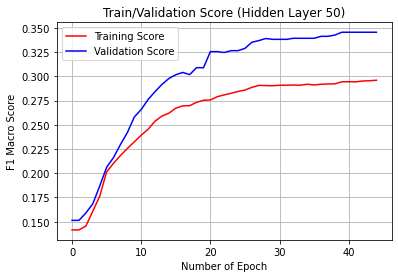

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Hidden Layer {})'.format(hidden_layer))

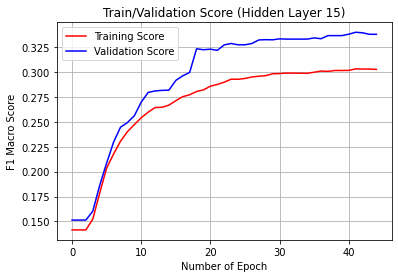

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (Hidden Layer {})'.format(hidden_layer))

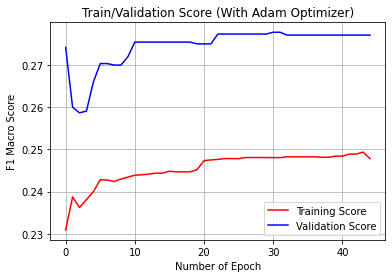

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (With Adam Optimizer)')

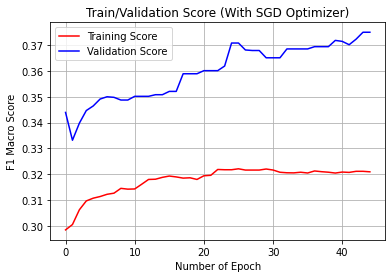

In [ ]:
plot_learning_curve_mlp(epoch_c, train_score, val_score, 'Number of Epoch', 'F1 Macro Score', 'Train/Validation Score (With SGD Optimizer)')

In [ ]:
check_accuracy(test_data_load, model)

Got 634 / 1225 with accuracy of 51.76
Average Precision Score: 0.67
Average recall Score: 0.67
Average f1-Score: 0.31


In [ ]:
check_accuracy(train_data_load, model)

Got 1660 / 3122 with accuracy of 53.17
Average Precision Score: 0.69
Average recall Score: 0.69
Average f1-Score: 0.32
